# *Bayesian A/B Testing and Conjugate Priors*
###### (Moses Marsh, Jack Bennetto) 

### Objectives: answer the following

 * What is a **prior distribution**, **likelihood function**, and **posterior distribution**?
 * What is a **conjugate prior**? 
 * How does this make Bayesian updating easier? How does this apply to **A/B testing**?
 * What are some key differences between frequentist and Bayesian A/B testing?

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats

# Review: frequentist p-values

*"The probability of observing data at least as extreme as the observation given the null hypothesis"*

How do we calculate this probability? Framing this in the most general terms, 
- we decide to measure some random variable $Y$
    - ($Y$ is often a sample statistic of some other random variable $X$)
- we decide on a hypothesis to test, such as "Y comes from a distribution with pdf $f_Y(y;\theta)$, where the value of parameter $\theta$ is $\theta_0$"
- we then sample from Y to get an observation, $y^*$
- we can then compute $P(Y \gt y^* \ |\  \theta = \theta_0)$

Broadly, we have a conditional probability (or probability density) 
$$P( \text{data} \ |\  \text{hypothesis} ) \rightarrow P( y^* |\  \theta_0 ) \rightarrow  f_Y(y^*;\theta_0) $$

Wouldn’t it be nice if, instead, we could give a probability of a ***hypothesis*** given the ***data***?

# Bayes' Theorem

Recall **Bayes' Theorem**

$$P(A|B) = \frac{P(B|A) P(A)}{P(B)}$$

When we use it in the context of statistics, we talk about the probability that a hypothesis $H$ is true, given some observed sample set $\mathbf{X}$.

$$P(H|\mathbf{X}) = \frac{P(\mathbf{X} | H) P(H)}{P(\mathbf{X})}$$

where

 * $P(H|\mathbf{X})$ is the **posterior probability distribution** of hypothesis $H$ being true, given observed data $\mathbf{X}$,
 * $P(\mathbf{X}|H)$ is the probability of observing $\mathbf{X}$ given $H$, also called the **likelihood**
 * $P(H)$ is the **prior distribution** of $H$, and
 * $P(\mathbf{X})$, the **normalizing constant**, is

$$P(\mathbf{X}) = \sum_H P(\mathbf{X}|H) P(H)$$


# Example: The Unknown Coin

Data is generated by the random variable $X$, which takes on the values 0 (tails) or 1 (heads)

$H: X \sim \text{Bernoulli}(p)$

This defines a *family* of hypotheses parametrized by $p$, the "fairness" of the coin.

...

*see `coin_example` notebook*

# Example: Click-through rates

Consider two version of an ad on a website, A and B, where we want to know which produces a higher click-through rate. We can model the click-throughs for each version as a Bernoulli distribution with an unknown probability. Each possible value of $p_A$ and $p_B$ is a separate hypothesis. We will use Bayesian analysis to find probability distributions for these hypotheses.
 
Recall earlier we talked about the probability of a biased coin flipping heads. We can take that same approach here, except instead of flipping heads we're seeing if a user clicks on an ad.

Let's work through that again.

# Binomial Distribution (likelihood)

Likelihood of k successes out of n trials is

$${n \choose k} p^k (1-p)^{n-k}$$

where

* $p$ is the conversion rate (between 0 and 1),
* $n$ is the number of visitors, and
* $k$ is the number of conversions.

# Beta Distribution

A beta distribution is a continuous distribution with support (e.g., possible values) between 0 and 1. It has two shape parameters, $\alpha$ and $\beta$. The pmf is given by

$$f(p; \alpha, \beta) = \frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{B(\alpha, \beta)}$$

where $B(\alpha, \beta)$ is the beta function (it's really just a normalizing factor and isn't that important).

If $\alpha = \beta = 1$ we have a *uniform distribution*. The expectation value is $\frac{\alpha}{\alpha + \beta}$.
Let's look at some curves.


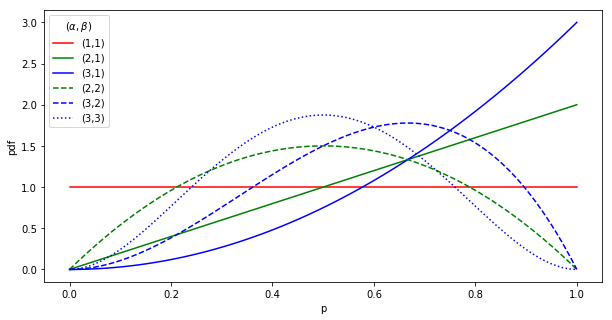

In [2]:
fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(0,1,100)
for (a,b,s) in [(1,1,"r-"), (2,1,"g-"), (3,1,"b-"), (2,2,"g--"), (3,2,"b--"), (3,3,"b:")]:
        ax.plot(x,
                stats.beta(a,b).pdf(x),
                s,
                label="({0},{1})".format(a,b))
ax.legend(title=r"($\alpha,\beta$)", loc="upper left")
ax.set_xlabel("p")
ax.set_ylabel("pdf")

You don't see the beta distribution that often, but one situation is in the distribution of ordered quantities. If you choose $n$ random values from $U(0,1)$, the distribution of the $k^\text{th}$ smallest is given by $Beta(k, n-k+1)$. So, for example, if the you choose five random numbers, the distribution of the 1st, 2nd, 3rd, 4th, and 5th numbers are given by the graphs below.

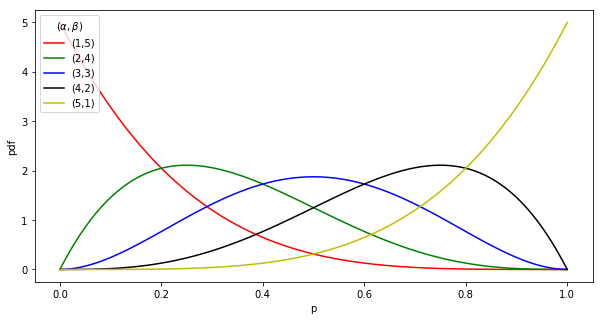

In [3]:
fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(0,1,100)
for (a,b,s) in [(1,5,"r-"), (2,4,"g-"), (3,3,"b-"), (4,2,"k-"), (5,1,"y-")]:
        ax.plot(x,
                stats.beta(a,b).pdf(x),
                s,
                label="({0},{1})".format(a,b))
ax.legend(title=r"($\alpha,\beta$)", loc="upper left")
ax.set_xlabel("p")
ax.set_ylabel("pdf")

But we're using the beta distribution for something else.

It turns out that if the prior probabilities are given by a beta distribution, and the likelihood function is given by a Bernoulli (or binomial) distribution, then the posterior distribution will also be given by a beta distribution. In this case the formula for 

$$f(p; \alpha, \beta) = \frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{B(\alpha, \beta)}$$

where

* $p$ is the conversion rate (**between 0 and 1**) and
* $\alpha$, $\beta$ are the shape parameters:
    * $\alpha$ = 1 + number of conversions and
    * $\beta$ = 1 + number of non-conversions.


### Conjugate Priors

The beta distribution is said to be a **conjugate prior** of the Bernoulli distribution.

$$\begin{aligned}
posterior &\propto prior * likelihood \\
beta &\propto beta * binomial \\
&= \frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{B(\alpha, \beta)} * {n \choose k} p^k (1-p)^{n-k} \\
&\propto p^{\alpha - 1}(1 - p)^{\beta - 1} * p^k (1-p)^{n-k} \\
&\propto p^{\alpha + k - 1}(1 - p)^{\beta + n - k - 1}
\end{aligned}$$

So the resulting posterior distribution is is a beta distribution with parameters $\alpha + k$ and $\beta + n - k$


A conjugate prior for a likelihood is a class of functions such that if the prior is in the class, so is the posterior. There are [many listed in Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).

Likelihood                 | Prior
---------------------------|------------
Bernoulli/Binomial         | Beta distribution
Normal with known $\sigma$ | Normal distribution
Poisson                    | Gamma
Uniform                    | Pareto

How important are these to doing Bayesian statistics?

## A/B testing

How do we turn this into A/B testing? Let's go back to comparing CTR for two different ads. We collect data for each ad, of how many successes and failures we get for each. Suppose it's something like:

In [4]:
success_a = 166
failure_a = 2540
success_b = 162
failure_b = 2132

Let's start with a uniform prior for the CTR for each. The happens to be a beta function, so we can use conjugate priors. Let graph the posteriors to see what they look like.

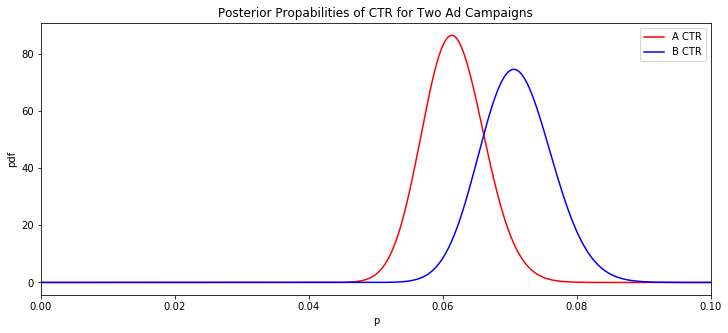

In [5]:
fig, ax = plt.subplots(figsize=(12,5))
x = np.linspace(0,1,10000)
for (a,b,s, label) in [(success_a+1, failure_a+1,"r", "A CTR"),
                       (success_b+1, failure_b+1,"b", "B CTR")]:
        ax.plot(x,
                stats.beta(a,b).pdf(x),
                s,
                label=label)
ax.legend(loc="upper right")
ax.set_xlabel("p")
ax.set_ylabel("pdf")
ax.set_xlim(0, 0.1)
ax.set_title("Posterior Propabilities of CTR for Two Ad Campaigns")

Suppose we want to know the probability that B is better than A. We have

In [6]:
prob_a = stats.beta(success_a+1, failure_a+1).pdf(x) / 10000
prob_b = stats.beta(success_b+1, failure_b+1).pdf(x) / 10000

Since it's a continuous problem it's a bit tough to manage, so we've done is divided the space from 0 to 1 into 10000 points, and calculated the probabilities (`prob_a` and `prob_b`) that CTR A and CTR B is each of those.

Since these are independent, we can calculate the joint probabilities by multiplying all the possible values together

In [7]:
joint_prob = prob_a * prob_b[:, None]

Now we can find the probability that the actual rate for B is greater than for A.

In [8]:
(joint_prob * (x < x[:, None])).sum()

0.90541669342495457

But we could have calculated *anything*. Want to know the probability that B is at least 10% better than A?

In [9]:
(joint_prob * (x*1.10 < x[:, None])).sum()

0.66494732337275408

## Frequentist vs. Bayesian

In both cases, we consider an ensemble of possible randomly generated universes.

Frequentist: The hypothesis is a fixed (though unknown) reality; the observed data follows some random distribution

Bayesian: The observed data is a fixed reality; the hypotheses follow some random distribution.

## Frequentist A/B testing

Frequentist procedure

* Choose n (number of experiments/samples) based on expected size of effect.
* Run **all** experiments and observe the data.
* The significance is probability of getting result (or more extreme) assuming no effect.
* Doesn't tell you how likely it is that a is better than b.

(aside: Wald sequential analysis)

## Bayesian A/B testing

Bayesian procedure

* No need to choose n beforehand.
* Update knowledge as the experiment runs.
* Gives probability of *anything you want*.

Why doesn't everyone like this better?